<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/master/Data_engineering_predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
!pip install pycountry_convert

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
import pycountry_convert as pc
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [210]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [211]:
loan.columns

Index(['id', 'description.languages', 'status', 'funded_amount', 'paid_amount',
       'activity', 'sector', 'location.country_code', 'location.country',
       'location.town', 'location.geo.level', 'partner_id',
       'borrowers.first_name', 'borrowers.last_name', 'borrowers.gender',
       'borrowers.pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'video.youtube_id', 'basket_amount', 'amount',
       'payment_id', 'local_amount', 'processed_date', 'rounded_local_amount',
       'settlement_date', 'lat', 'lon'],
      dtype='object')

In [212]:
db_desc.columns

Index(['id', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrower_names', 'borrower_genders',
       'borrower_pictured', 'repayment_interval', 'distribution_model'],
      dtype='object')

In [213]:
## On identifie les variables présentent dans les deux bases
loan.filter(items=db_desc.columns).columns

Index(['id', 'partner_id'], dtype='object')

In [214]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [215]:
db_desc.head()

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner
2,183,Piedad Portillo,I am a baker who can do all kids of baking to ...,NaN,Money to increase inventory and happiness.,HN,Honduras,Siguatepeque,standard,NaN,5,12,3,NaN,Piedad Portillo,female,true,monthly,field_partner
3,186,Braulia,I make all different kinds of Ã\xadtems for my...,NaN,Working Capital,HN,Honduras,Siguatepeque,standard,NaN,5,6,9,NaN,Braulia,female,true,monthly,field_partner
4,200,Joan,<i>This business is a member of the Golden Cro...,NaN,Expand business to one larger room.,KE,Kenya,Ongata Rongai,standard,NaN,6,12,3,NaN,Joan,female,true,monthly,field_partner


In [216]:
loan.head()

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333
2,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,616.0,50,31/07/2006,50,16/09/2006,12.150833,-86.268333
3,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,913.0,270,17/08/2006,270,16/09/2006,12.150833,-86.268333
4,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,1283.0,80,16/09/2006,80,16/09/2006,12.150833,-86.268333


### Drop dupplicates observations

In [217]:
## Nombre de données dupliqués sur la base des id
loan.duplicated(subset=['id' ]).sum()

37177

In [218]:
## Nombre de données dupliqués sur la base des id et du status
loan.duplicated(subset=['id', 'status']).sum()

37177

In [219]:
#stats desc on dupplicates obs
loan.loc[loan.id.duplicated()].count()

id                                        37177
description.languages                     26875
status                                    37177
funded_amount                             37177
paid_amount                               36671
activity                                  37177
sector                                    37177
location.country_code                     36312
location.country                          37177
location.town                             36536
location.geo.level                        37154
partner_id                                37154
borrowers.first_name                      37148
borrowers.last_name                       34912
borrowers.gender                          37107
borrowers.pictured                        37118
terms.disbursal_amount                    37105
terms.disbursal_currency                  37094
terms.disbursal_date                      37118
terms.loan_amount                         37107
terms.loss_liability.nonpayment         

In [220]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [221]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.head()

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
5,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833
10,183,en,paid,500,500,Bakery,Food,HN,Honduras,Siguatepeque,town,5,Piedad Portillo,Arias,F,True,500,USD,14/04/2005,500.0,partner,none,15/03/2006,31/03/2005,2.0,21/11/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,200.0,35,20/04/2006,35,21/11/2006,14.600000,-87.833333
19,186,en,paid,500,500,Tailoring,Services,HN,Honduras,Siguatepeque,town,5,Braulia,Maldonado,F,True,500,USD,14/04/2005,500.0,partner,none,15/03/2006,31/03/2005,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,189.0,35,20/04/2006,35,NaN,14.600000,-87.833333
22,200,en,paid,575,575,Beauty Salon,Services,KE,Kenya,Ongata Rongai,town,6,Joan,Wanjiru,F,True,575,USD,14/04/2005,575.0,partner,none,15/03/2006,31/03/2005,2.0,02/05/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,435.0,114,12/06/2006,114,02/05/2007,-0.866667,36.433333


In [222]:
data.shape

(5004, 42)

In [223]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [224]:
#There are some mistakes in this variables
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [225]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data.shape

(5002, 42)

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5002 entries, 0 to 42173
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5002 non-null   object 
 1   description.languages                   3265 non-null   object 
 2   status                                  5002 non-null   object 
 3   funded_amount                           5002 non-null   object 
 4   paid_amount                             4902 non-null   object 
 5   activity                                5002 non-null   object 
 6   sector                                  5002 non-null   object 
 7   location.country_code                   4960 non-null   object 
 8   location.country                        5002 non-null   object 
 9   location.town                           4869 non-null   object 
 10  location.geo.level                      5000 non-null   obj

In [227]:
#list of potential unusual/ususal variables
unusual = ['description.languages','country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]
usual = ['id','funded_amount','status','sector','location.country','location.town','repayment_interval','terms.disbursal_amount','terms.disbursal_date','terms.loss_liability.nonpayment','posted_date','funded_date','paid_date','defaulted_date','amount','borrowers.gender',"borrowers.pictured","journal_totals.entries",'basket_amount', 'delinquent']
#list of renames variables
renam = ['location.country','location.town','location.geo.level','borrowers.gender','terms.disbursal_amount','terms.disbursal_currency','terms.disbursal_date','terms.loan_amount','terms.loss_liability.nonpayment','terms.loss_liability.currency_exchange','terms.local_payments.due_date','terms.local_payments.amount','terms.scheduled_payments.due_date','terms.scheduled_payments.amount']

In [228]:
data = data.filter(items=usual)
data.shape

(5002, 19)

In [229]:
data.head()

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_amount,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,paid_date,defaulted_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,basket_amount,delinquent
0,156,500,paid,Construction,Nicaragua,Managua,500,14/04/2005,partner,15/02/2006,31/03/2005,16/09/2006,NaN,50.0,M,True,1.0,NaN,NaN
5,173,600,defaulted,Construction,Gaza,Rafah,600,14/04/2005,lender,15/02/2006,31/03/2005,11/09/2007,11/09/2007,50.0,M,True,7.0,NaN,NaN
10,183,500,paid,Food,Honduras,Siguatepeque,500,14/04/2005,partner,15/03/2006,31/03/2005,21/11/2006,NaN,35.0,F,True,2.0,NaN,NaN
19,186,500,paid,Services,Honduras,Siguatepeque,500,14/04/2005,partner,15/03/2006,31/03/2005,NaN,NaN,35.0,F,True,2.0,NaN,NaN
22,200,575,paid,Services,Kenya,Ongata Rongai,575,14/04/2005,partner,15/03/2006,31/03/2005,02/05/2007,NaN,114.0,F,True,2.0,NaN,NaN


### Merge dataset laon with description

These dataset do not have the same size we are going to merge them

In [230]:
#data = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [231]:
#data.info()

In [232]:
##usual.append('repayment_interval')
##data = data.filter(items=usual)

In [233]:
data.shape

(5002, 19)

<BarContainer object of 19 artists>

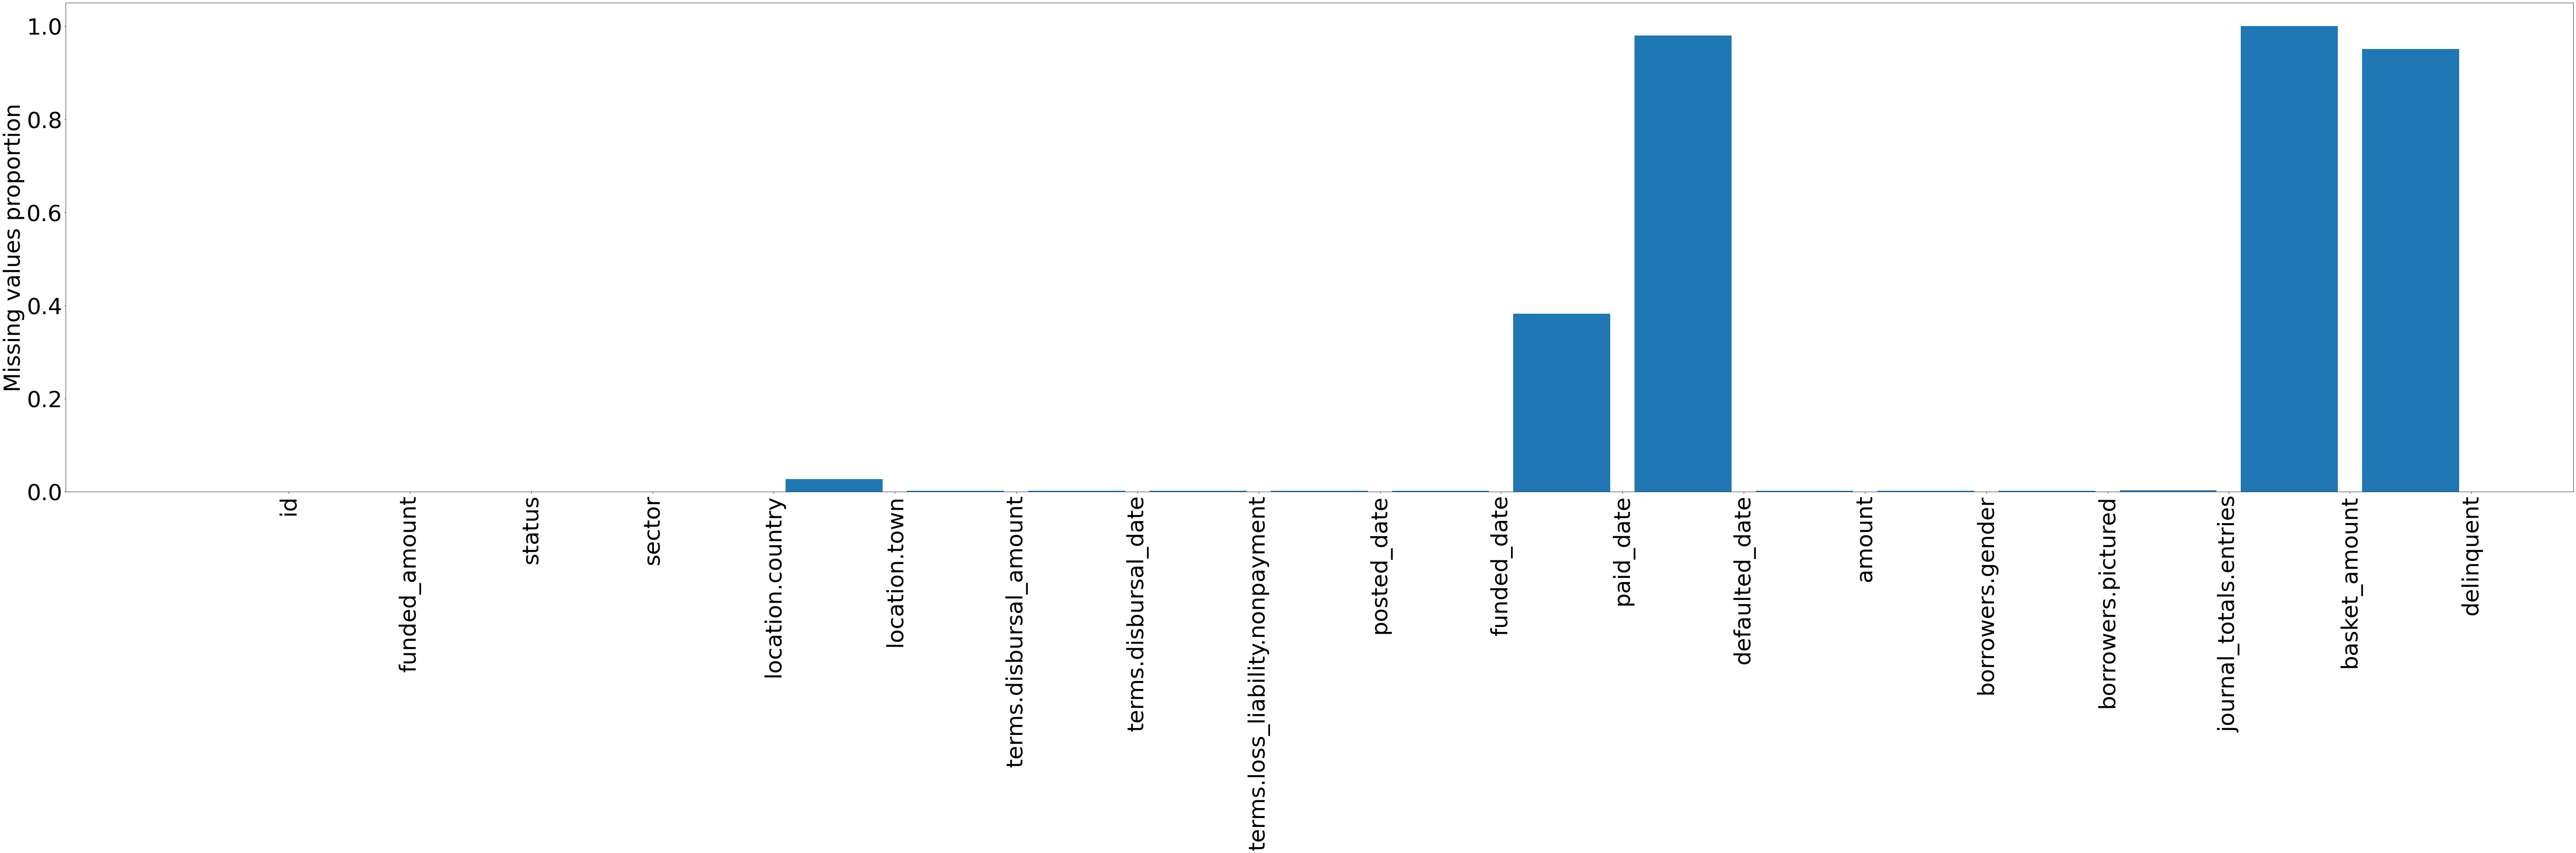

In [234]:
## Missing values visualization
null_counts = data.isnull().sum()/len(data)
plt.figure(figsize=(100,20))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical', fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Missing values proportion', fontsize=50)
plt.bar(np.arange(len(null_counts)),null_counts)

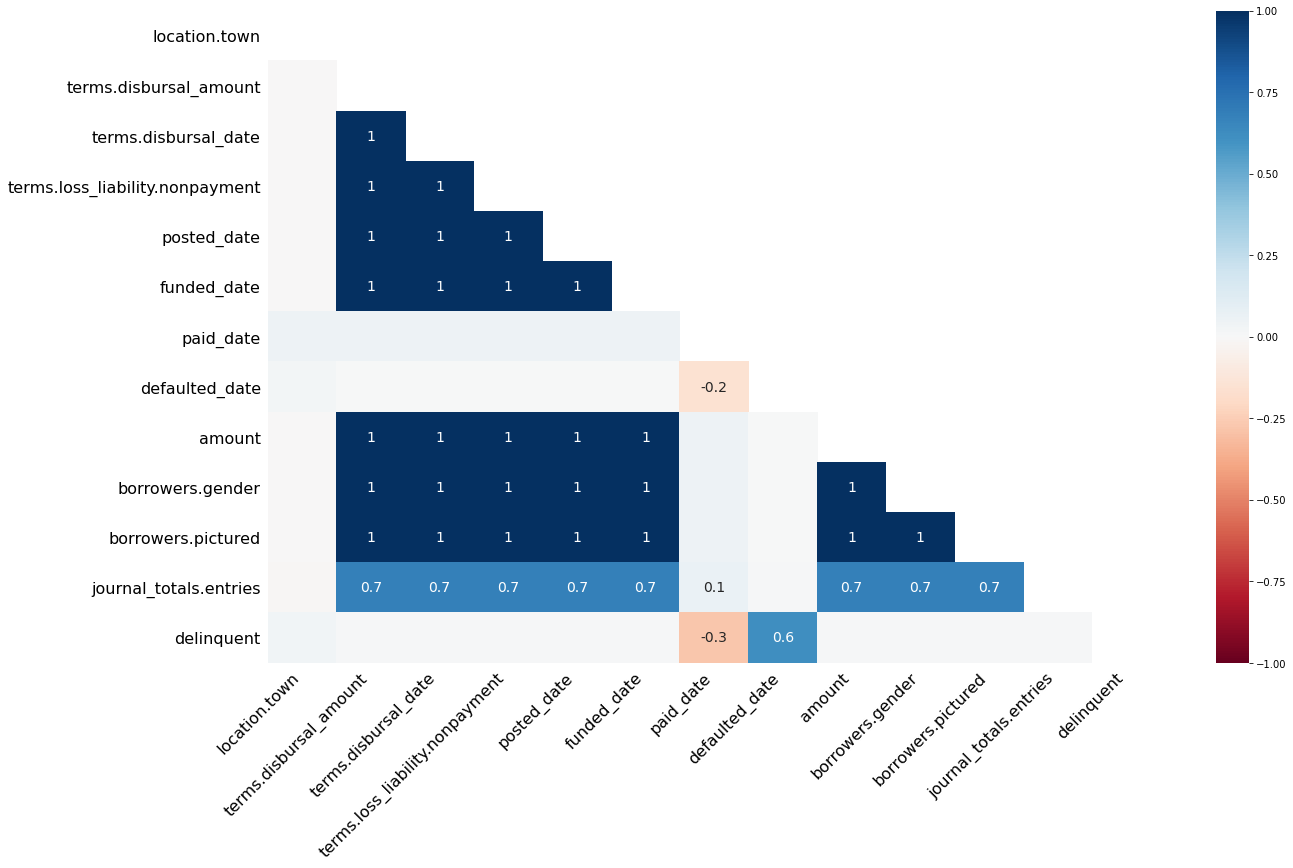

In [235]:

msno.heatmap(data)

In [236]:
pd.crosstab(data.status,"freq")

col_0,freq
status,
defaulted,100
in_repayment,1818
paid,3084


In [237]:
data['close_date'] = np.where(data["defaulted_date"].isnull(), data["paid_date"], data["defaulted_date"] )

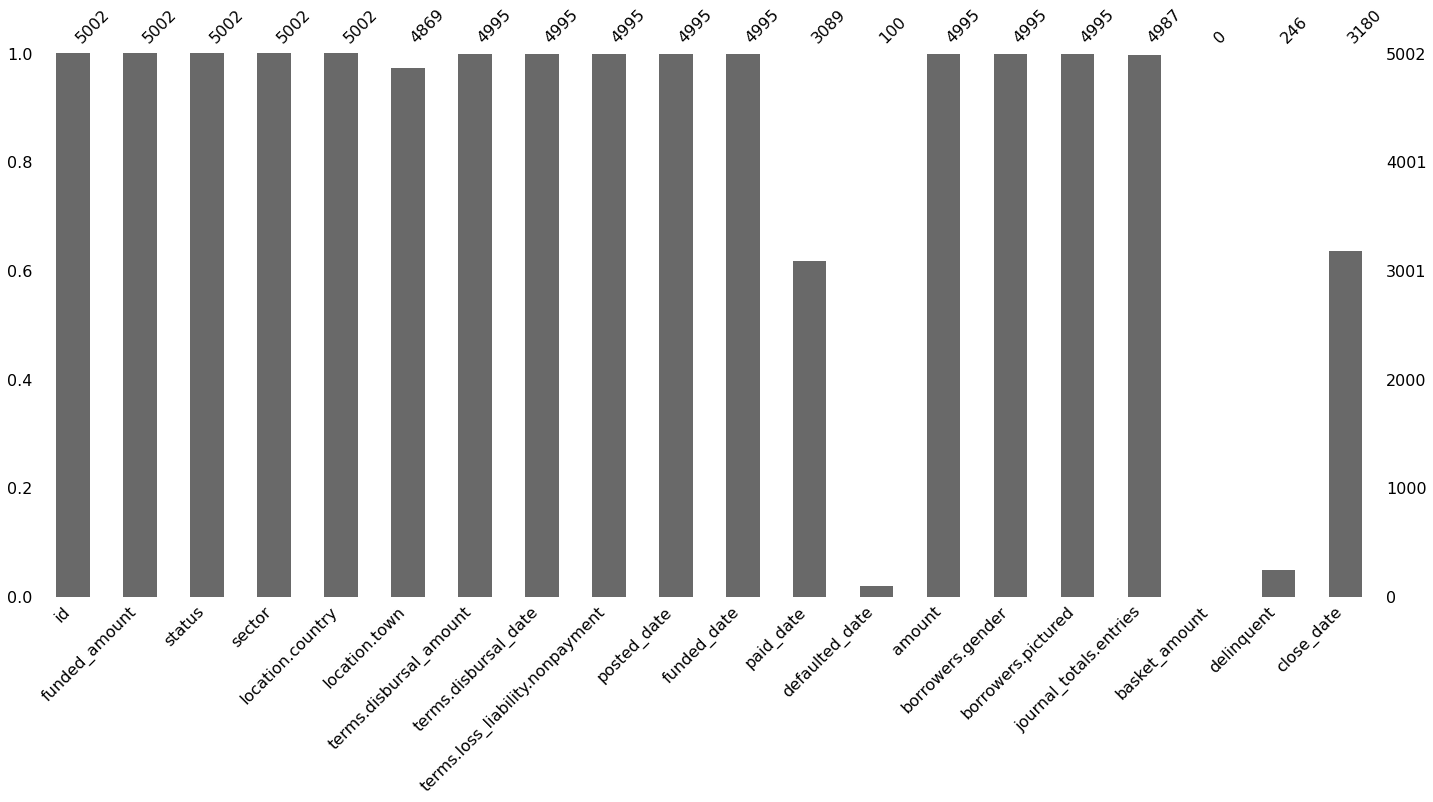

In [238]:
msno.bar(data)

In [239]:
# We keep only paid and defaulted observations
data = data[data.status != 'in_repayment']

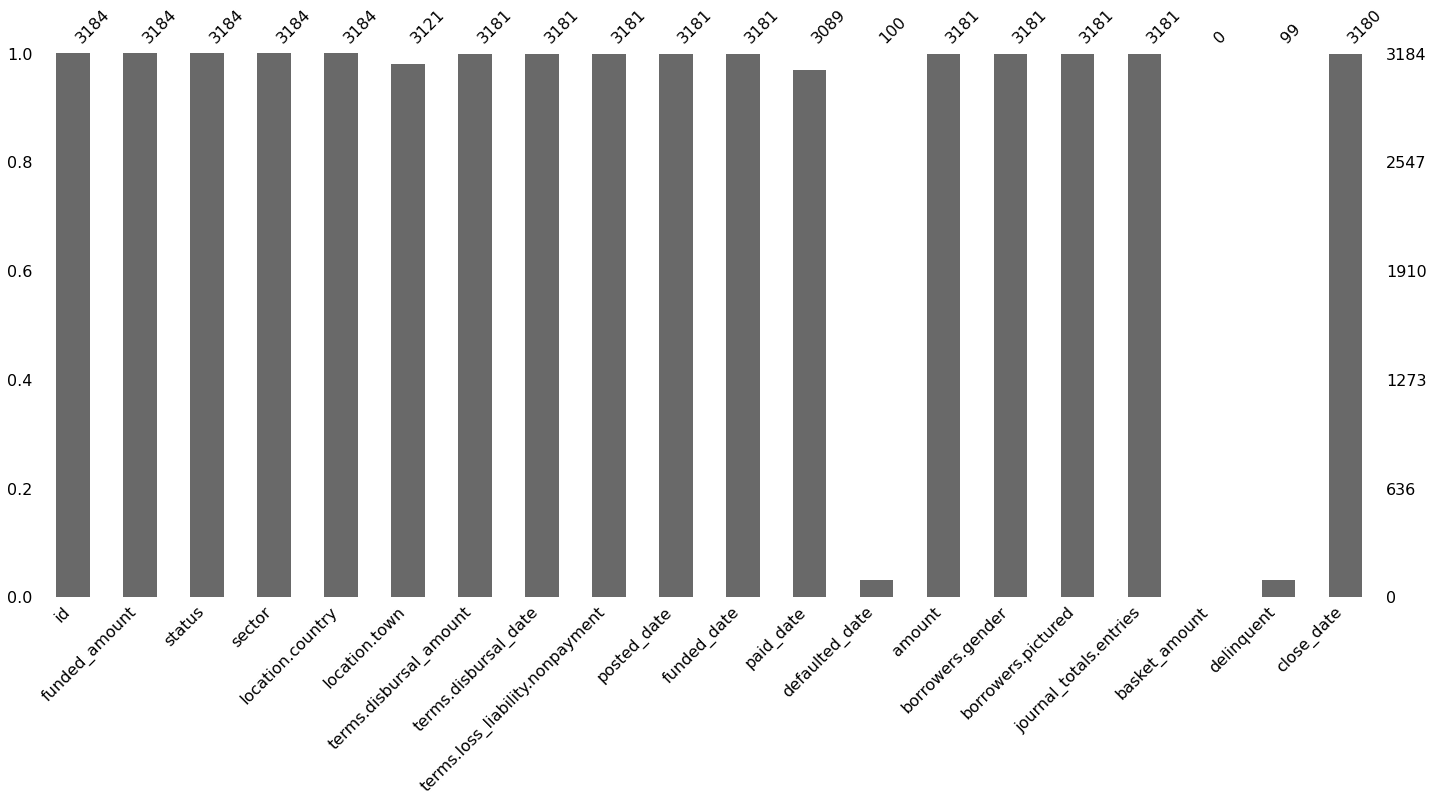

In [240]:
msno.bar(data)

In [241]:
pd.crosstab(data.status,data.delinquent)

delinquent,True,TRUE
status,,
defaulted,49,50


In [242]:
# We drop some variables with too many missing values
var_to_delete = ['basket_amount','defaulted_date', 'paid_date','delinquent']
data = data.drop(var_to_delete, axis=1)

In [243]:
test = data.dropna(axis=0)
test.shape

(3117, 16)

In [244]:
pd.crosstab(test.status,"freq")
# Only paid observations have missing values 

col_0,freq
status,
defaulted,100
paid,3017


In [245]:
data = data.dropna(axis=0)

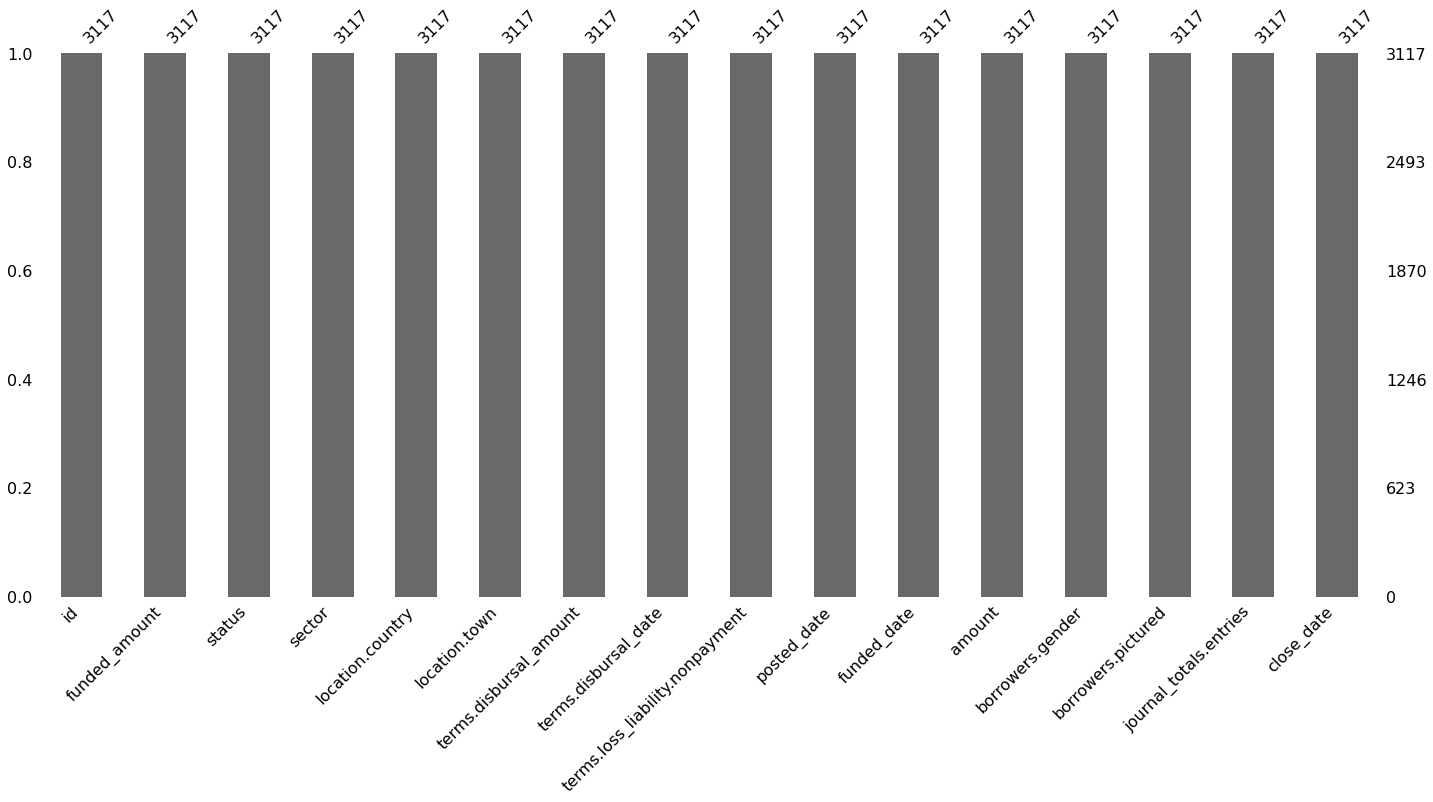

In [246]:
msno.bar(data)
# we are going to work with this database

### Target variable

In [247]:
pd.crosstab(data.status,"freq")

col_0,freq
status,
defaulted,100
paid,3017


In [248]:
conditions = [
    (data.status == 'defaulted'),
    (data.status == 'paid')
]
values = [1,0]

In [249]:
data['target'] = np.select(conditions, values)

In [250]:
pd.crosstab(data.target,"freq")

col_0,freq
target,
0,3017
1,100


In [251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 42165
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3117 non-null   object 
 1   funded_amount                    3117 non-null   object 
 2   status                           3117 non-null   object 
 3   sector                           3117 non-null   object 
 4   location.country                 3117 non-null   object 
 5   location.town                    3117 non-null   object 
 6   terms.disbursal_amount           3117 non-null   object 
 7   terms.disbursal_date             3117 non-null   object 
 8   terms.loss_liability.nonpayment  3117 non-null   object 
 9   posted_date                      3117 non-null   object 
 10  funded_date                      3117 non-null   object 
 11  amount                           3117 non-null   float64
 12  borrowers.gender   

In [252]:
data = data.drop('terms.disbursal_amount', axis=1)

In [253]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')

# Categorical variables

In [254]:
categorical_var = ['sector', 'location.country','location.town', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date','borrowers.gender', 'borrowers.pictured','close_date']
date_var = ['terms.disbursal_date','posted_date', 'funded_date','close_date']
data[categorical_var] = data[categorical_var].astype('category')
data['borrowers.gender'] = data['borrowers.gender'].cat.codes
#data['borrowers.pictured'] = data['borrowers.pictured'].cat.codes
data['terms.loss_liability.nonpayment'] = data['terms.loss_liability.nonpayment'].cat.codes

#### variable sector

In [255]:
# checking modalities of variable sector
data.sector.value_counts()

Food              951
Retail            715
Agriculture       533
Clothing          278
Services          266
Arts               94
Transportation     92
Construction       75
Manufacturing      35
Health             30
Housing            25
Wholesale          11
Personal Use        6
Education           4
Entertainment       2
Name: sector, dtype: int64

In [256]:
# We can group the sector variable 
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
data['sector_cat'] = np.where(data['sector'].isin(others), "Other", data['sector'])

In [257]:
data.sector.unique()

['Construction', 'Food', 'Services', 'Clothing', 'Agriculture', ..., 'Health', 'Personal Use', 'Wholesale', 'Entertainment', 'Education']
Length: 15
Categories (15, object): ['Construction', 'Food', 'Services', 'Clothing', ..., 'Personal Use',
                          'Wholesale', 'Entertainment', 'Education']

In [258]:
Bien_Menage = ['Clothing','Housing','Personnal Use']
autre_secteur = ['Services','Education','Transportation','Arts','Health','Construction','Manufacturing','Entertainment','Wholesale']
conditions = [
    (data.sector == 'Agriculture'),
    (data.sector == 'Food'),
    (data.sector == 'Retail'),
    (data.sector == 'Clothing') | (data.sector == 'Housing') | (data.sector == 'Personal Use'),
    (data.sector == 'Services') | (data.sector == 'Education') | (data.sector == 'Transportation') | (data.sector == 'Arts') | (data.sector == 'Health') | (data.sector == 'Services') | (data.sector == 'Construction') |  (data.sector == 'Manufacturing') | (data.sector == 'Entertainment') | (data.sector == 'Wholesale')
]
values = ['Agriculture','Food','Retail','Bien_Menage','autre_secteur']
data.sector = np.select(conditions, values)

pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.10
Bien_Menage,9.91
Food,30.51
Retail,22.94
autre_secteur,19.54


#### Borrower gender

In [259]:

data.rename(columns={'borrowers.gender':'gender'}, inplace = True)
len(pd.unique(data['gender']))

2

In [260]:
# inspect missing values 
pd.crosstab(data['gender'].isna(),'freq')


col_0,freq
gender,
False,3117


#### Country

In [261]:
# grouping the country due to their continent
def pays_par_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'

data['CONTINENT'] = data['location.country'].apply(pays_par_continent)

#vérification du rendu :
data['CONTINENT'].unique()

array(['North America', 'Unknown', 'Africa', 'Europe', 'Asia', 'Oceania',
       'South America'], dtype=object)

In [262]:
# We have the modality Unknown which we are going to give the real value
# looking for the country correspond to unknow
data[data['CONTINENT']=='Unknown']['location.country'].unique()

['Gaza', 'The Democratic Republic of the Congo', 'Cote D'Ivoire']
Categories (3, object): ['Gaza', 'The Democratic Republic of the Congo', 'Cote D'Ivoire']

In [263]:
# changing the name of variable country
data.rename(columns={'location.country':'country_name'}, inplace = True)

In [264]:
data.CONTINENT = np.where((data.country_name == 'The Democratic Republic of the Congo') | (data.country_name == "Cote D'Ivoire"),'Africa',data.CONTINENT)
data.CONTINENT = np.where((data.country_name == 'Gaza'),'Asia',data.CONTINENT)

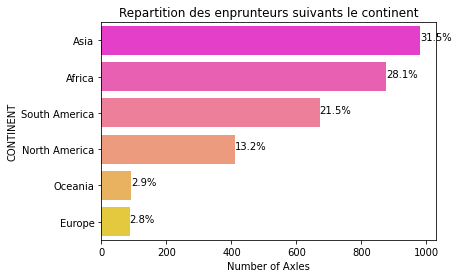

In [265]:
ax = sns.countplot(y="CONTINENT", data=data, order =data['CONTINENT'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivants le continent')
plt.xlabel('Number of Axles')

total = len(data['CONTINENT'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

####  borrowers pictured

In [268]:

data.rename(columns={'borrowers.pictured':'borrower_pictured'}, inplace = True)

pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0,freq
borrower_pictured,
True,50.336862
FALSE,0.096246
TRUE,49.566891


In [283]:
data['borrower_pictured'].head()

0     True
5     True
10    True
22    True
31    True
Name: borrower_pictured, dtype: category
Categories (3, object): [True, 'FALSE', 'TRUE']

In [284]:
conditions = [
    (data.borrower_pictured == 'TRUE') | (data.borrower_pictured == True),
    data.borrower_pictured == 'FALSE'
]
values = ['TRUE','FALSE']

data['borrower_pictured'] = np.select(conditions, values)
pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0,freq
borrower_pictured,
FALSE,0.096246
TRUE,99.903754


#### Processing on date variables

In [285]:

# Conversting variables on datetime


data["posted_date"] = pd.to_datetime(data["posted_date"])
data["funded_date"] = pd.to_datetime(data["funded_date"])
data["terms.disbursal_date"] = pd.to_datetime(data["terms.disbursal_date"])
#data["settlement_date"] = pd.to_datetime(data["settlement_date"])

data["posted_date"].dt
data["funded_date"].dt
data["terms.disbursal_date"].dt
#data["settlement_date"].dt

# Ajout des variables années à notre dataset
data["posted_date"] = data["posted_date"].dt.year
data["funded_date"] = data["funded_date"].dt.year
data["terms.disbursal_date"] = data["terms.disbursal_date"].dt.year
#data["settlement_date"] = data["settlement_date"].dt.year

# Définition des variables pour la représentation graphique
df1 = pd.crosstab(data["posted_date"],"freq")
df2 = pd.crosstab(data["funded_date"],"freq")
df3 = pd.crosstab(data["terms.disbursal_date"],"freq")
#df4 = pd.crosstab(data["settlement_date"],"freq")

#### Processing numerical variable

In [286]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')
data['amount'] = pd.to_numeric(data['amount'], downcast='float')

numerical_col = data.select_dtypes(include =["number"]).columns.values
numerical_col

array(['funded_amount', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date',
       'amount', 'gender', 'journal_totals.entries', 'target'],
      dtype=object)

In [287]:
var_quanti = ['amount','funded_amount','journal_totals.entries']
data[var_quanti].describe()

,amount,funded_amount,journal_totals.entries
count,3117.000000,3117.000000,3117.000000
mean,106.272484,675.007996,1.457170
std,139.723633,581.075378,0.675429
min,0.080000,25.000000,1.000000
25%,42.000000,325.000000,1.000000
50%,69.000000,525.000000,1.000000
75%,110.000000,900.000000,2.000000
max,1818.099976,5000.000000,7.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


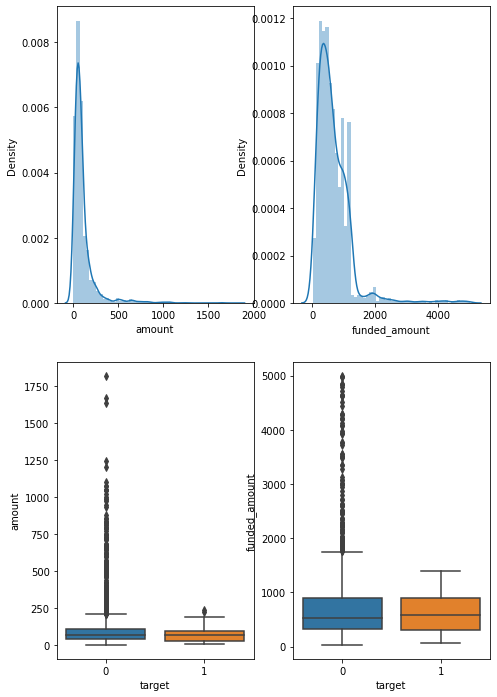

In [288]:
numerical_cols1 = ['amount','funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,3,i)
    sns.distplot(data[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

In [289]:
# Remplacement des données 95% percetile value
Q4 = data['amount'].quantile(0.90) # Get 90th quantile
print("frequency of amount : ",len(data[data['amount'] >= Q4]))
data.loc[data['amount'] >= Q4, 'paid_amount'] = Q4 # outlier capping

Q4 = data['funded_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de funded_amount est de :",len(data[data['funded_amount'] >= Q4]))
data.loc[data['funded_amount'] >= Q4, 'funded_amount'] = Q4 # outlier capping

frequency of amount :  338
Le nombre total de funded_amount est de : 359


### Exporting processed data  to use for next step

In [290]:
# Save the data without dummy
data.to_csv('/content/drive/My Drive/Stat_App/data_for_stat_desc.csv',index = False)



# Ctreating data with dummies

In [293]:
#We can create dummy variables
data = pd.get_dummies(data, columns=['sector_cat','CONTINENT'], prefix = ['sector','CONTINENT'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 42165
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   id                               3117 non-null   object  
 1   funded_amount                    3117 non-null   float32 
 2   status                           3117 non-null   object  
 3   sector                           3117 non-null   object  
 4   country_name                     3117 non-null   category
 5   location.town                    3117 non-null   category
 6   terms.disbursal_date             3117 non-null   int64   
 7   terms.loss_liability.nonpayment  3117 non-null   int8    
 8   posted_date                      3117 non-null   int64   
 9   funded_date                      3117 non-null   int64   
 10  amount                           3117 non-null   float32 
 11  gender                           3117 non-null   int8    
 12  borro

In [294]:
# Save the data with dummies
data.to_csv('/content/drive/My Drive/Stat_App/data_with_dummies.csv',index = False)
